In [1]:
using CSV, DataFrames
using Plots; gr();
using LsqFit
using Printf
using Optim

$$
Corr(\tau) = Corr(n\Delta t) = \langle P_{control}(m\Delta t)\cdot P_{perturbed}(m\Delta t + n\Delta t)\rangle
$$

Where $\langle\cdot\rangle$ denotes Pearson correlation. 

$P$ is fluorescence polarization

In [2]:
function corr(n, X, Y)
    M = length(X)
    
    if n >= 0
        X_mean = sum(X[1:(end - n)])/(M - n)
        Y_mean = sum(Y[(n + 1):end])/(M - n)
        X1 = X[1:(end - n)] .- X_mean
        Y1 = Y[(n + 1):end] .- Y_mean
    else
        n = abs(n)
        X_mean = sum(X[(n + 1):end])/(M - n)
        Y_mean = sum(Y[1:(end - n)])/(M - n)
        X1 = X[(n + 1):end] .- X_mean
        Y1 = Y[1:(end - n)] .- Y_mean
    end
    
    r = X1'*Y1/sqrt(X1'*X1)/sqrt(Y1'*Y1)
end

corr (generic function with 1 method)

$$ \phi = CT/24*2\pi$$

In [3]:
# read
df = CSV.read("data/20240914_growth_response_curve_M25_Dphi2.csv", DataFrame)
rename!(df, ["Nr", "Time_h", "Time_s", "Temp", names(df)[5:end]...])

# ditch some columns
select!(df, Not([:Nr, :Time_s, :C9, :D9, :E9]))
    
# pivot longer
df_l = stack(df, Not([:Time_h, :Temp]), variable_name=:Position, value_name=:FP)

# parse plate position to treatments and circadian times
df_l[!, :Treatment] = (x -> x[1] == 'C' ? :Control : :Perturbed).(df_l[!, :Position])
well2CT = (x, offset) -> mod(-(x - offset)*2, 24)

df_l[!, :CT] = @. well2CT(parse(Int64, [x[2:end] for x in df_l.Position]), 
    ifelse([x[1] for x in df_l.Position] == 'D', 3 + 6, 3))

# select!(df_l, Not([:Position]))    # keep well number. will be useful
df_l

5202×6 DataFrame
  Row │ Time_h     Temp     Position  FP     Treatment  CT    
      │ Float64    Float64  String    Int64  Symbol     Int64 
──────┼───────────────────────────────────────────────────────
    1 │  0.0          30.0  C3          155  Control        0
    2 │  0.250056     30.0  C3          148  Control        0
    3 │  0.500056     30.0  C3          147  Control        0
    4 │  0.750056     30.1  C3          148  Control        0
    5 │  1.00006      30.1  C3          149  Control        0
    6 │  1.25008      30.1  C3          150  Control        0
    7 │  1.50008      30.1  C3          150  Control        0
    8 │  1.75008      30.3  C3          150  Control        0
    9 │  2.00008      30.2  C3          151  Control        0
   10 │  2.25008      30.2  C3          151  Control        0
   11 │  2.50008      30.0  C3          152  Control        0
  ⋮   │     ⋮         ⋮        ⋮        ⋮        ⋮        ⋮
 5193 │ 69.7513       30.1  E8          164  Perturbed     14
 5194 │ 70.0013       30.1  E8          165  Perturbed     14
 5195 │ 70.2513       30.2  E8          163  Perturbed     14
 5196 │ 70.5013       30.1  E8          165  Perturbed     14
 5197 │ 70.7513       30.2  E8          164  Perturbed     14
 5198 │ 71.0013       30.2  E8          165  Perturbed     14
 5199 │ 71.2513       30.0  E8          165  Perturbed     14
 5200 │ 71.5014       30.4  E8          164  Perturbed     14
 5201 │ 71.7514       30.2  E8          165  Perturbed     14
 5202 │ 72.0014       30.0  E8          165  Perturbed     14
                                             5181 rows omitted

Calculate time-correlation between control and perturbed

In [4]:
T_TRUNC = 6.

corr_dict = Dict()

for CT in unique(df_l[!, :CT])
    corr_vec = []
    for i in -24:24    # up to 6 hours
        if CT >= 2 && CT <= 12
            r = corr(i, df_l[df_l.CT .== mod(CT + 12, 24) .&& df_l.Treatment .== :Control .&& df_l.Time_h .> T_TRUNC, :FP],
                        df_l[df_l.CT .== CT .&& df_l.Treatment .== :Perturbed .&& df_l.Time_h .> T_TRUNC, :FP])
        else
            r = corr(i, df_l[df_l.CT .== CT .&& df_l.Treatment .== :Control .&& df_l.Time_h .> T_TRUNC, :FP],
                        df_l[df_l.CT .== CT .&& df_l.Treatment .== :Perturbed .&& df_l.Time_h .> T_TRUNC, :FP])
        end

        corr_vec = [corr_vec; r]
    end
    corr_dict[CT] = corr_vec
end

Fit the phase to

$$
P(t) = B + A\sin(\frac{2\pi}{T}\cdot t + \phi - \frac{\pi}{2})
$$

In [5]:
function model(t, p)
    T, ϕ, A, B = p
    @. B + A*sin(2π/T*t + ϕ - π/2)
end

function my_error(t, y, p_many)
    n = (length(p_many) - 1)÷3    # number of traces
    ye = []    # y estimate
    T = p_many[1]
    
    for i in 1:n
        p_rest = p_many[(3i - 1):(3i + 1)]
        ye = [ye; model(t, [T; p_rest])]
    end
    
    sum((y .- ye).^2)
end

my_error (generic function with 1 method)

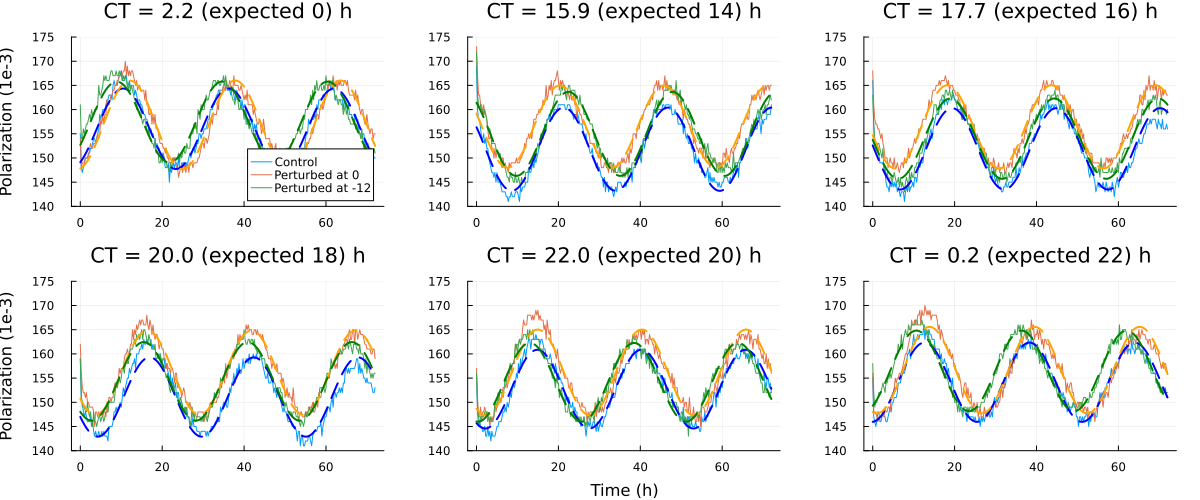

Dict{Int64, Float64} with 12 entries:
  16 => 1.09356
  20 => -0.126868
  12 => 1.45633
  8  => 1.7142
  0  => -1.47844
  22 => -1.15187
  6  => 1.37681
  4  => 0.427621
  2  => -1.062
  10 => 1.83351
  18 => 0.53204
  14 => 0.894107

In [6]:
p_vec = []

p0 = [24., 0., 10., 160., 0., 10., 160., 0., 10., 160.]
lb = [0., -π, 3., 0., -π, 3., 0., -π, 3., 0.]
ub = [100., π, 100., 200., π, 100., 200., π, 100., 200.]


T_TRUNC = 6.

fitted_ϕ₀ = Dict()
fitted_ϕp = Dict()

for CT in sort([0; 14:2:22])
        tmp = df_l[df_l.CT .== CT, :]
        tmp_c = tmp[tmp.Treatment .== :Control .&& tmp.Time_h .> T_TRUNC, :]
        tmp_p = @. tmp[tmp.Treatment == :Perturbed && tmp.Time_h > T_TRUNC, :]
        tmp_p2 = @. df_l[df_l.CT == mod(CT - 12, 24) && df_l.Treatment == :Perturbed && df_l.Time_h > T_TRUNC, :]

        # fit the model
        fit = optimize(p -> my_error(tmp_c.Time_h, [tmp_c.FP; tmp_p.FP; tmp_p2.FP], p),
            lb, ub, p0, Fminbox(BFGS()))
        coefs = Optim.minimizer(fit)
    
        ϕ₀ = mod(coefs[2], 2π)
        fitted_ϕ₀[CT] = ϕ₀*24/2π
        fitted_ϕ₀[mod(CT - 12, 24)] = mod(ϕ₀*24/2π - 12, 24)
    
        ϕp = mod(coefs[5], 2π)
        ϕp2 = mod(coefs[8], 2π)
        fitted_ϕp[CT] = ϕp*24/2π
        fitted_ϕp[mod(CT - 12, 24)] = ϕp2*24/2π
        
        p = plot(tmp[tmp[!, :Treatment] .== :Control, :Time_h],
            tmp[tmp[!, :Treatment] .== :Control, :FP], 
            label="Control", title=(@sprintf "CT = %.1f (expected %i) h" fitted_ϕ₀[CT] CT),
            xlabel=CT == 20 ? "Time (h)" : "", ylabel=CT ∈ (0, 18) ? "Polarization (1e-3)" : "",
            ylim=(140, 175), legend=CT==0 ? :best : false)
        plot!(tmp[tmp[!, :Treatment] .== :Perturbed, :Time_h],
                tmp[tmp[!, :Treatment] .== :Perturbed, :FP], label="Perturbed at 0")
        plot!(df_l[df_l.CT .== mod(CT - 12, 24) .&& df_l.Treatment .== :Perturbed, :Time_h],
                df_l[df_l.CT .== mod(CT - 12, 24) .&& df_l.Treatment .== :Perturbed, :FP], label="Perturbed at -12")
        
        # fitted curve
        t_vec = 0:0.1:maximum(tmp_c.Time_h)
        plot!(t_vec, model(t_vec, [coefs[1]; coefs[2:4]]), style=:dash, width=2, color=:blue, label=false)
        plot!(t_vec, model(t_vec, [coefs[1]; coefs[5:7]]), style=:dash, width=2, color=:orange, label=false)
        plot!(t_vec, model(t_vec, [coefs[1]; coefs[8:10]]), style=:dash, width=2, color=:green, label=false)
        p_vec = [p_vec; p]
end
pp = plot(p_vec..., layout=(2, 3), 
        size=(1200, 500), margin=4Plots.mm, fmt=:png)
display(pp)

Δϕ_dict = Dict(CT => (CT >= 2 && CT <= 12) ? mod(fitted_ϕp[CT] - fitted_ϕ₀[mod(CT - 12, 24)], 24) :
    mod(fitted_ϕp[CT] - fitted_ϕ₀[CT], 24) for CT in 0:2:22)
Δϕ_dict = Dict(CT => Δϕ > 12 ? Δϕ - 24 : Δϕ for (CT, Δϕ) in Δϕ_dict)

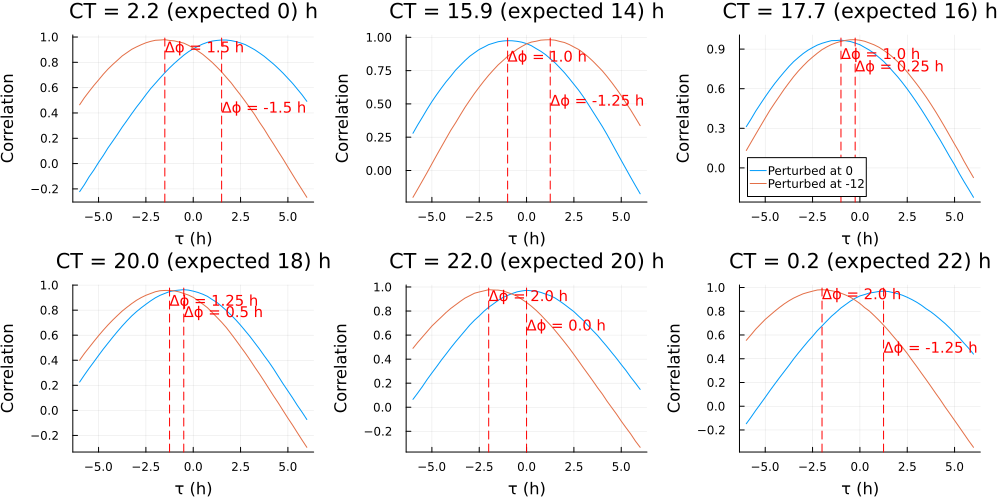

In [7]:
p_vec = []

Δϕ_dict2 = Dict()

for CT in [0; 14:2:22]
    p = plot(-6:0.25:6, corr_dict[CT], 
            title=(@sprintf "CT = %.1f (expected %i) h" fitted_ϕ₀[CT] CT), 
            label="Perturbed at 0", legend=CT == 16 ? :bottomleft : false, xlabel="τ (h)", ylabel="Correlation")
    plot!(-6:0.25:6, corr_dict[mod(CT - 12, 24)], 
            label="Perturbed at -12")
    
    imax = argmax((i -> corr_dict[CT][i]), 1:length(corr_dict[CT]))
    Δϕ = (imax - 25)*0.25
    Δϕ_dict2[CT] = abs(Δϕ) < 1e-6 ? 0. : -Δϕ
    vline!([Δϕ], c=:red, style=:dash, label=false)
    annotate!(Δϕ, corr_dict[CT][13],
            text("Δϕ = $(Δϕ_dict2[CT]) h", :left, :red, 10))
    
    imax2 = argmax((i -> corr_dict[mod(CT - 12, 24)][i]), 1:length(corr_dict[mod(CT - 12, 24)]))
    Δϕ2 = (imax2 - 25)*0.25
    Δϕ_dict2[mod(CT - 12, 24)] = abs(Δϕ2) < 1e-6 ? 0. : -Δϕ2
    vline!([Δϕ2], c=:red, style=:dash, label=false)
    annotate!(Δϕ2, corr_dict[mod(CT - 12, 24)][13],
            text("Δϕ = $(Δϕ_dict2[mod(CT - 12, 24)]) h", :left, :red, 10))
    
    p_vec = [p_vec; p]
end

pp = plot(p_vec..., layout=(2, 3), 
        size=(1000, 500), margin=3Plots.mm, fmt=:png)
display(pp)

Get control phase by time correlation

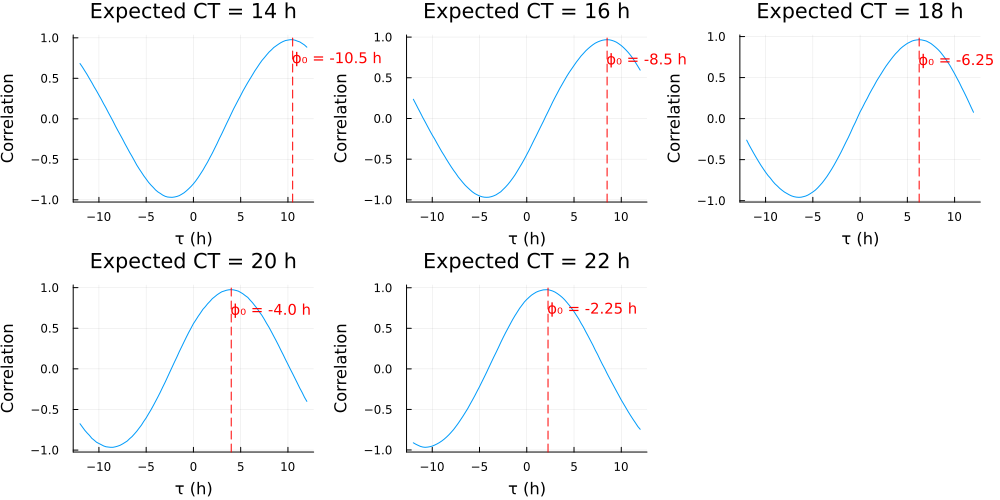

In [8]:
# calculate correlations between controls
corr_ctrl = Dict()

for CT in [0; 14:2:22]
    if CT == 0
        continue
    end
    
    corr_vec = []
    for i in -48:48    # up to 12 hours
        r = corr(i, df_l[df_l.CT .== 0 .&& df_l.Treatment .== :Control .&& df_l.Time_h .> 12., :FP],
                    df_l[df_l.CT .== CT .&& df_l.Treatment .== :Control .&& df_l.Time_h .> 12., :FP])
        corr_vec = [corr_vec; r]
    end
    corr_ctrl[CT] = corr_vec
end

# plot and extract the maximum
p_vec = []

fitted_ϕ₀2 = Dict()
fitted_ϕ₀2[0] = 0    # arbitrarily chosen
fitted_ϕ₀2[12] = 12

for CT in [0; 14:2:22]
    if CT == 0
        continue
    end

    p = plot(-12:0.25:12, corr_ctrl[CT],
            title=(@sprintf "Expected CT = %i h" CT), 
            legend=false, xlabel="τ (h)", ylabel="Correlation")
    imax = argmax((i -> corr_ctrl[CT][i]), 1:length(corr_ctrl[CT]))
    Δϕ = (imax - 49)*0.25
    fitted_ϕ₀2[CT] = Δϕ > 0 ? -Δϕ + 24 : -Δϕ
    fitted_ϕ₀2[mod(CT - 12, 24)] = mod(fitted_ϕ₀2[CT] - 12, 24)
    vline!([Δϕ], c=:red, style=:dash)
    annotate!(Δϕ, corr_ctrl[CT][imax - 12],
            text("ϕ₀ = $(-Δϕ) h", CT == 12 ? :right : :left, :red, 10))
    p_vec = [p_vec; p]
end

pp = plot(p_vec..., layout=(2, 3), 
        size=(1000, 500), margin=3Plots.mm, fmt=:png)
display(pp)

In [9]:
# adding a baseline to ϕ₀ fit using time correlation
CT_vec = 0:2:22
fitted_ϕ₀2_bl = Dict(CT => mod(fitted_ϕ₀2[CT] + fitted_ϕ₀[0], 24) for CT in CT_vec)

Dict{Int64, Float64} with 12 entries:
  16 => 17.7446
  20 => 22.2446
  12 => 14.2446
  8  => 10.2446
  0  => 2.24464
  22 => 23.9946
  6  => 7.99464
  14 => 15.7446
  4  => 5.74464
  2  => 3.74464
  10 => 11.9946
  18 => 19.9946

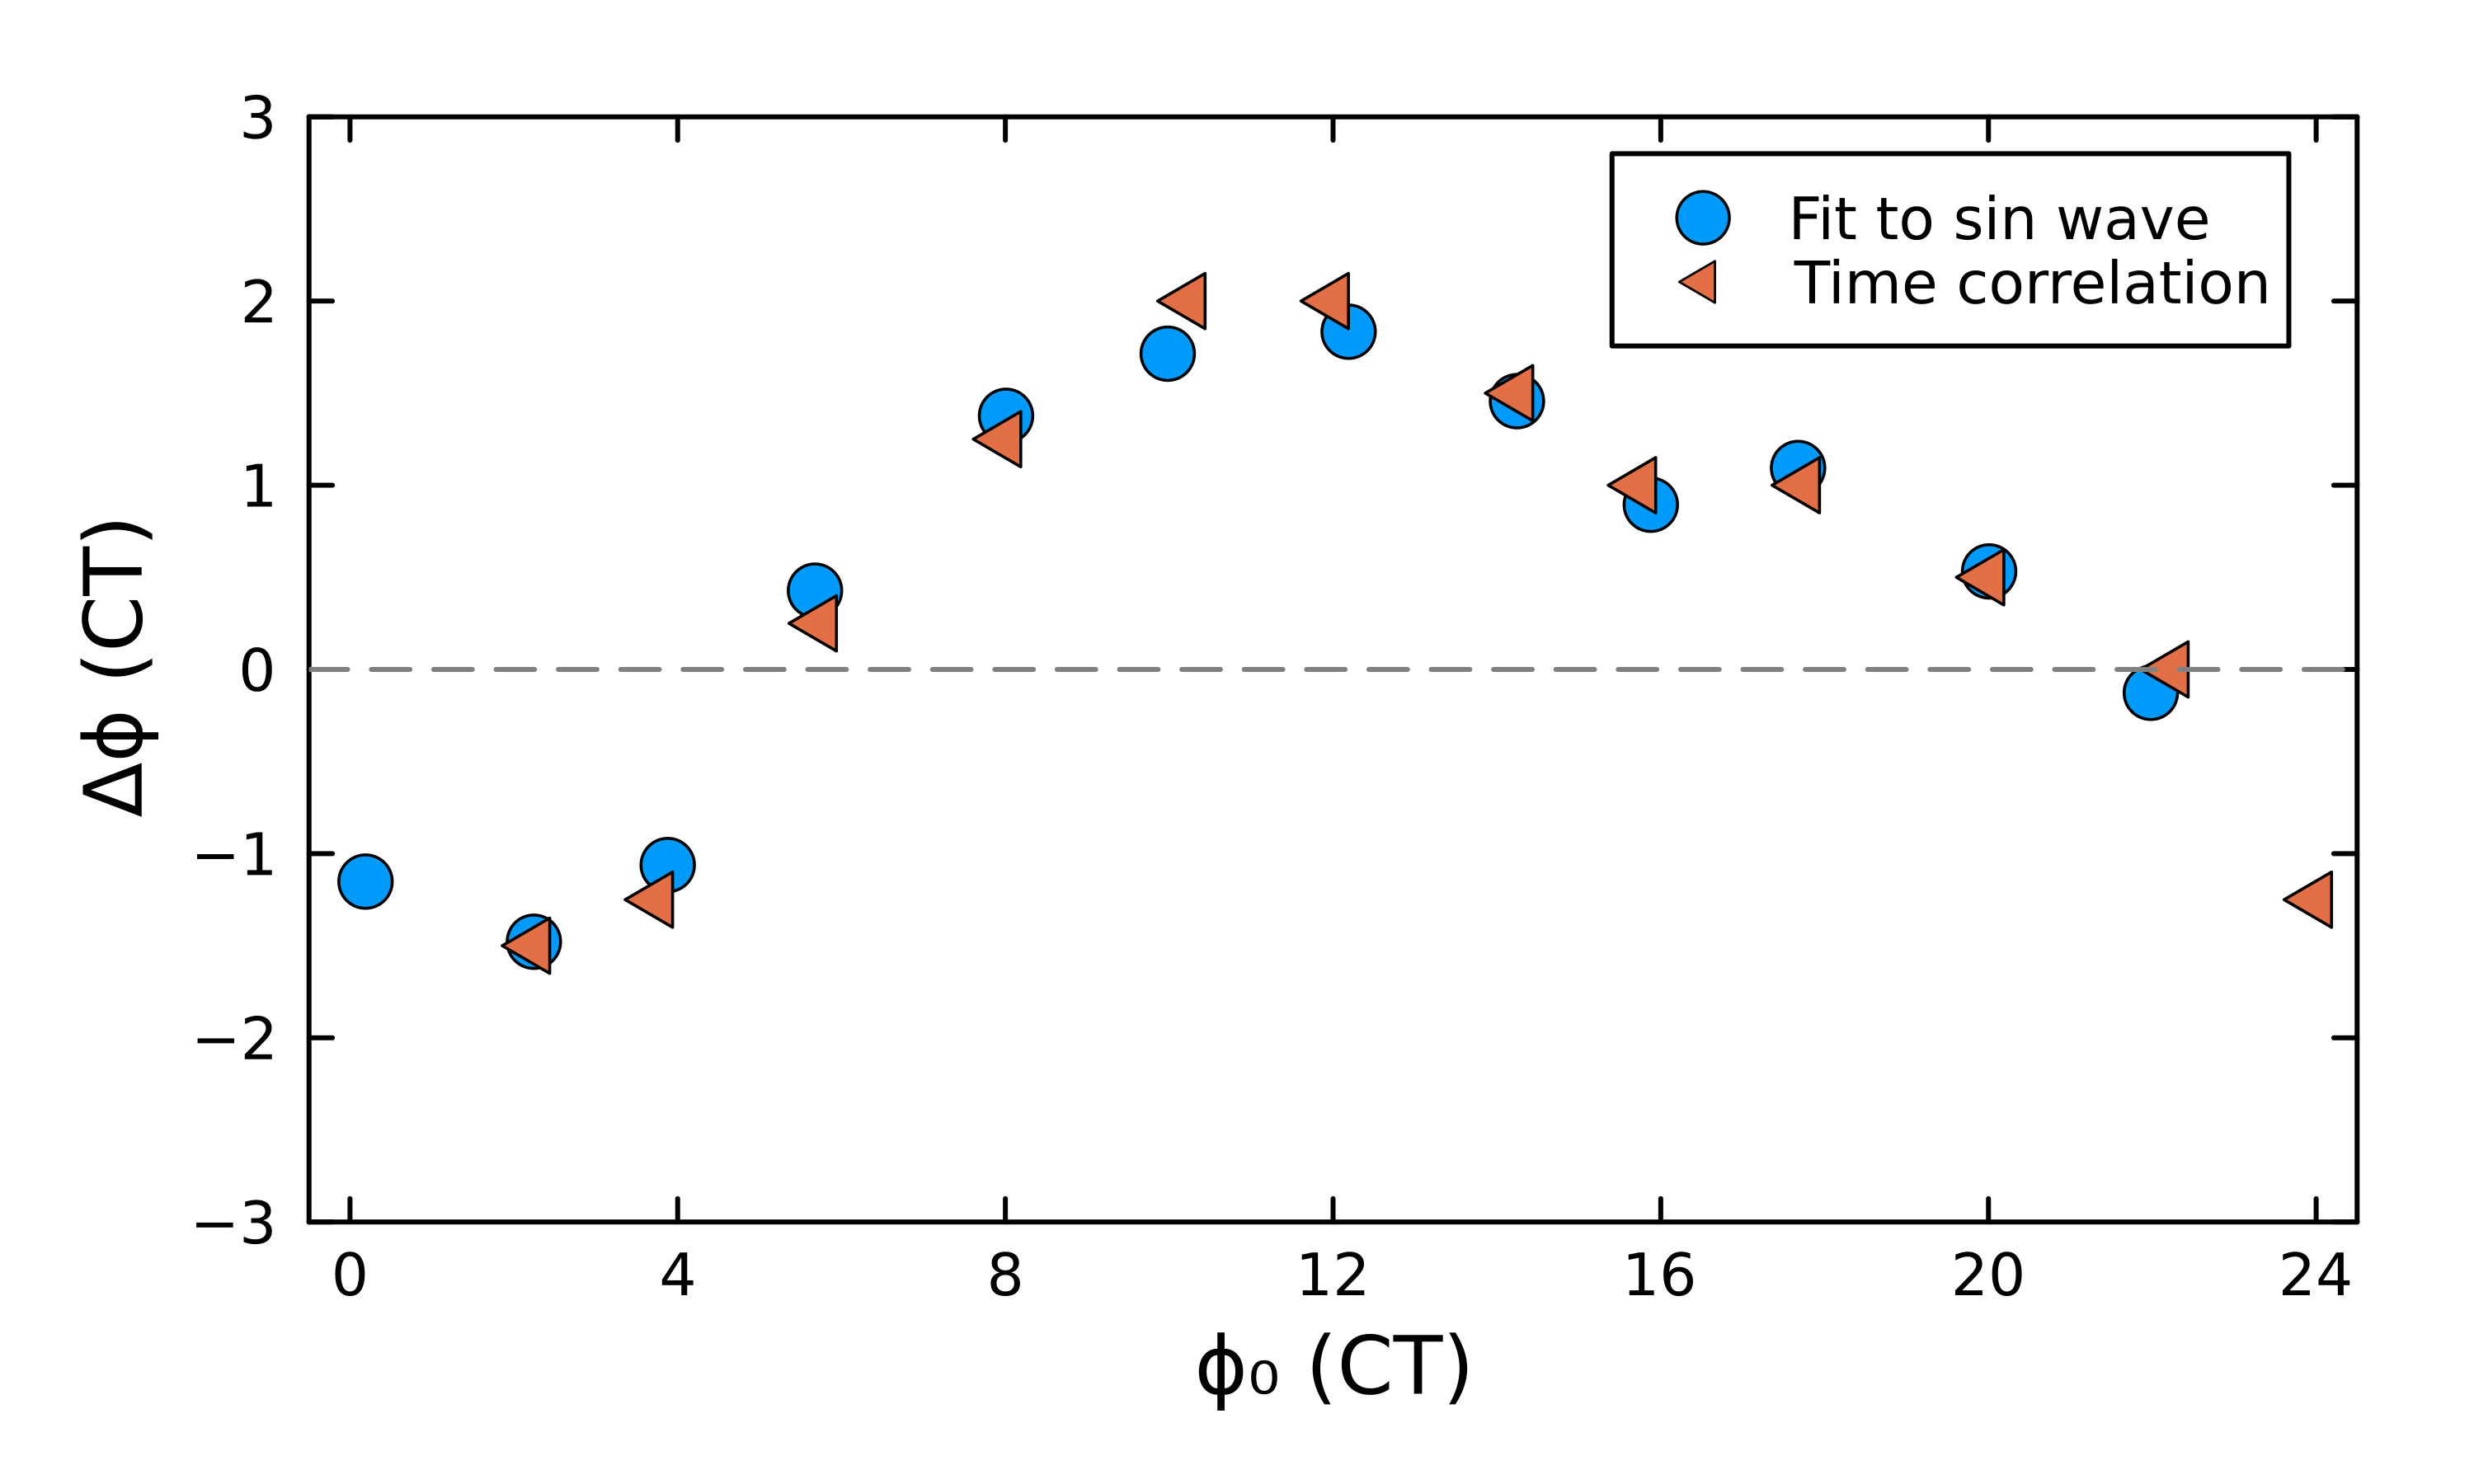

In [10]:
CT_vec = 0:2:22

pp = scatter([fitted_ϕ₀[CT] for CT in CT_vec],
    [Δϕ_dict[CT] for CT in CT_vec],
    markersize=6, xlabel="ϕ₀ (CT)", ylabel="Δϕ (CT)", 
    xlim=(-0.5, 24.5), xticks=0:4:24, ylim=(-3, 3),
    frame=:box, grid=false, label="Fit to sin wave", fmt=:png,
    size=(500, 300), dpi=600, margins=4Plots.mm)

scatter!([fitted_ϕ₀2_bl[CT] for CT in CT_vec],
        [Δϕ_dict2[CT] for CT in CT_vec],
        markersize = 8, label="Time correlation", markershape=:ltriangle)

hline!([0.], style=:dash, color=:gray, label=:none, z=-2)

Fit PRC to continuous functions

$$
\Delta\phi(\phi_0)/\text{CT} = A_0 + A_1\cos(\phi_0 - \psi_1) + A_2\cos(2\phi_0 - \psi_2)
$$

In [11]:
function prc_model(ϕ₀, p)
    A0, A1, ψ1, A2, ψ2 = p
    @. A0 + A1*cos(ϕ₀ - ψ1) + A2*cos(2ϕ₀ - ψ2)
end

prc_model (generic function with 1 method)

Fit
A₀ = 0.49
A₁ = 1.45
ψ₁ = 3.37
A₂ = 0.54
ψ₂ = 4.38
Time correlation
A₀ = 0.49
A₁ = 1.54
ψ₁ = 3.40
A₂ = 0.57
ψ₂ = 4.60


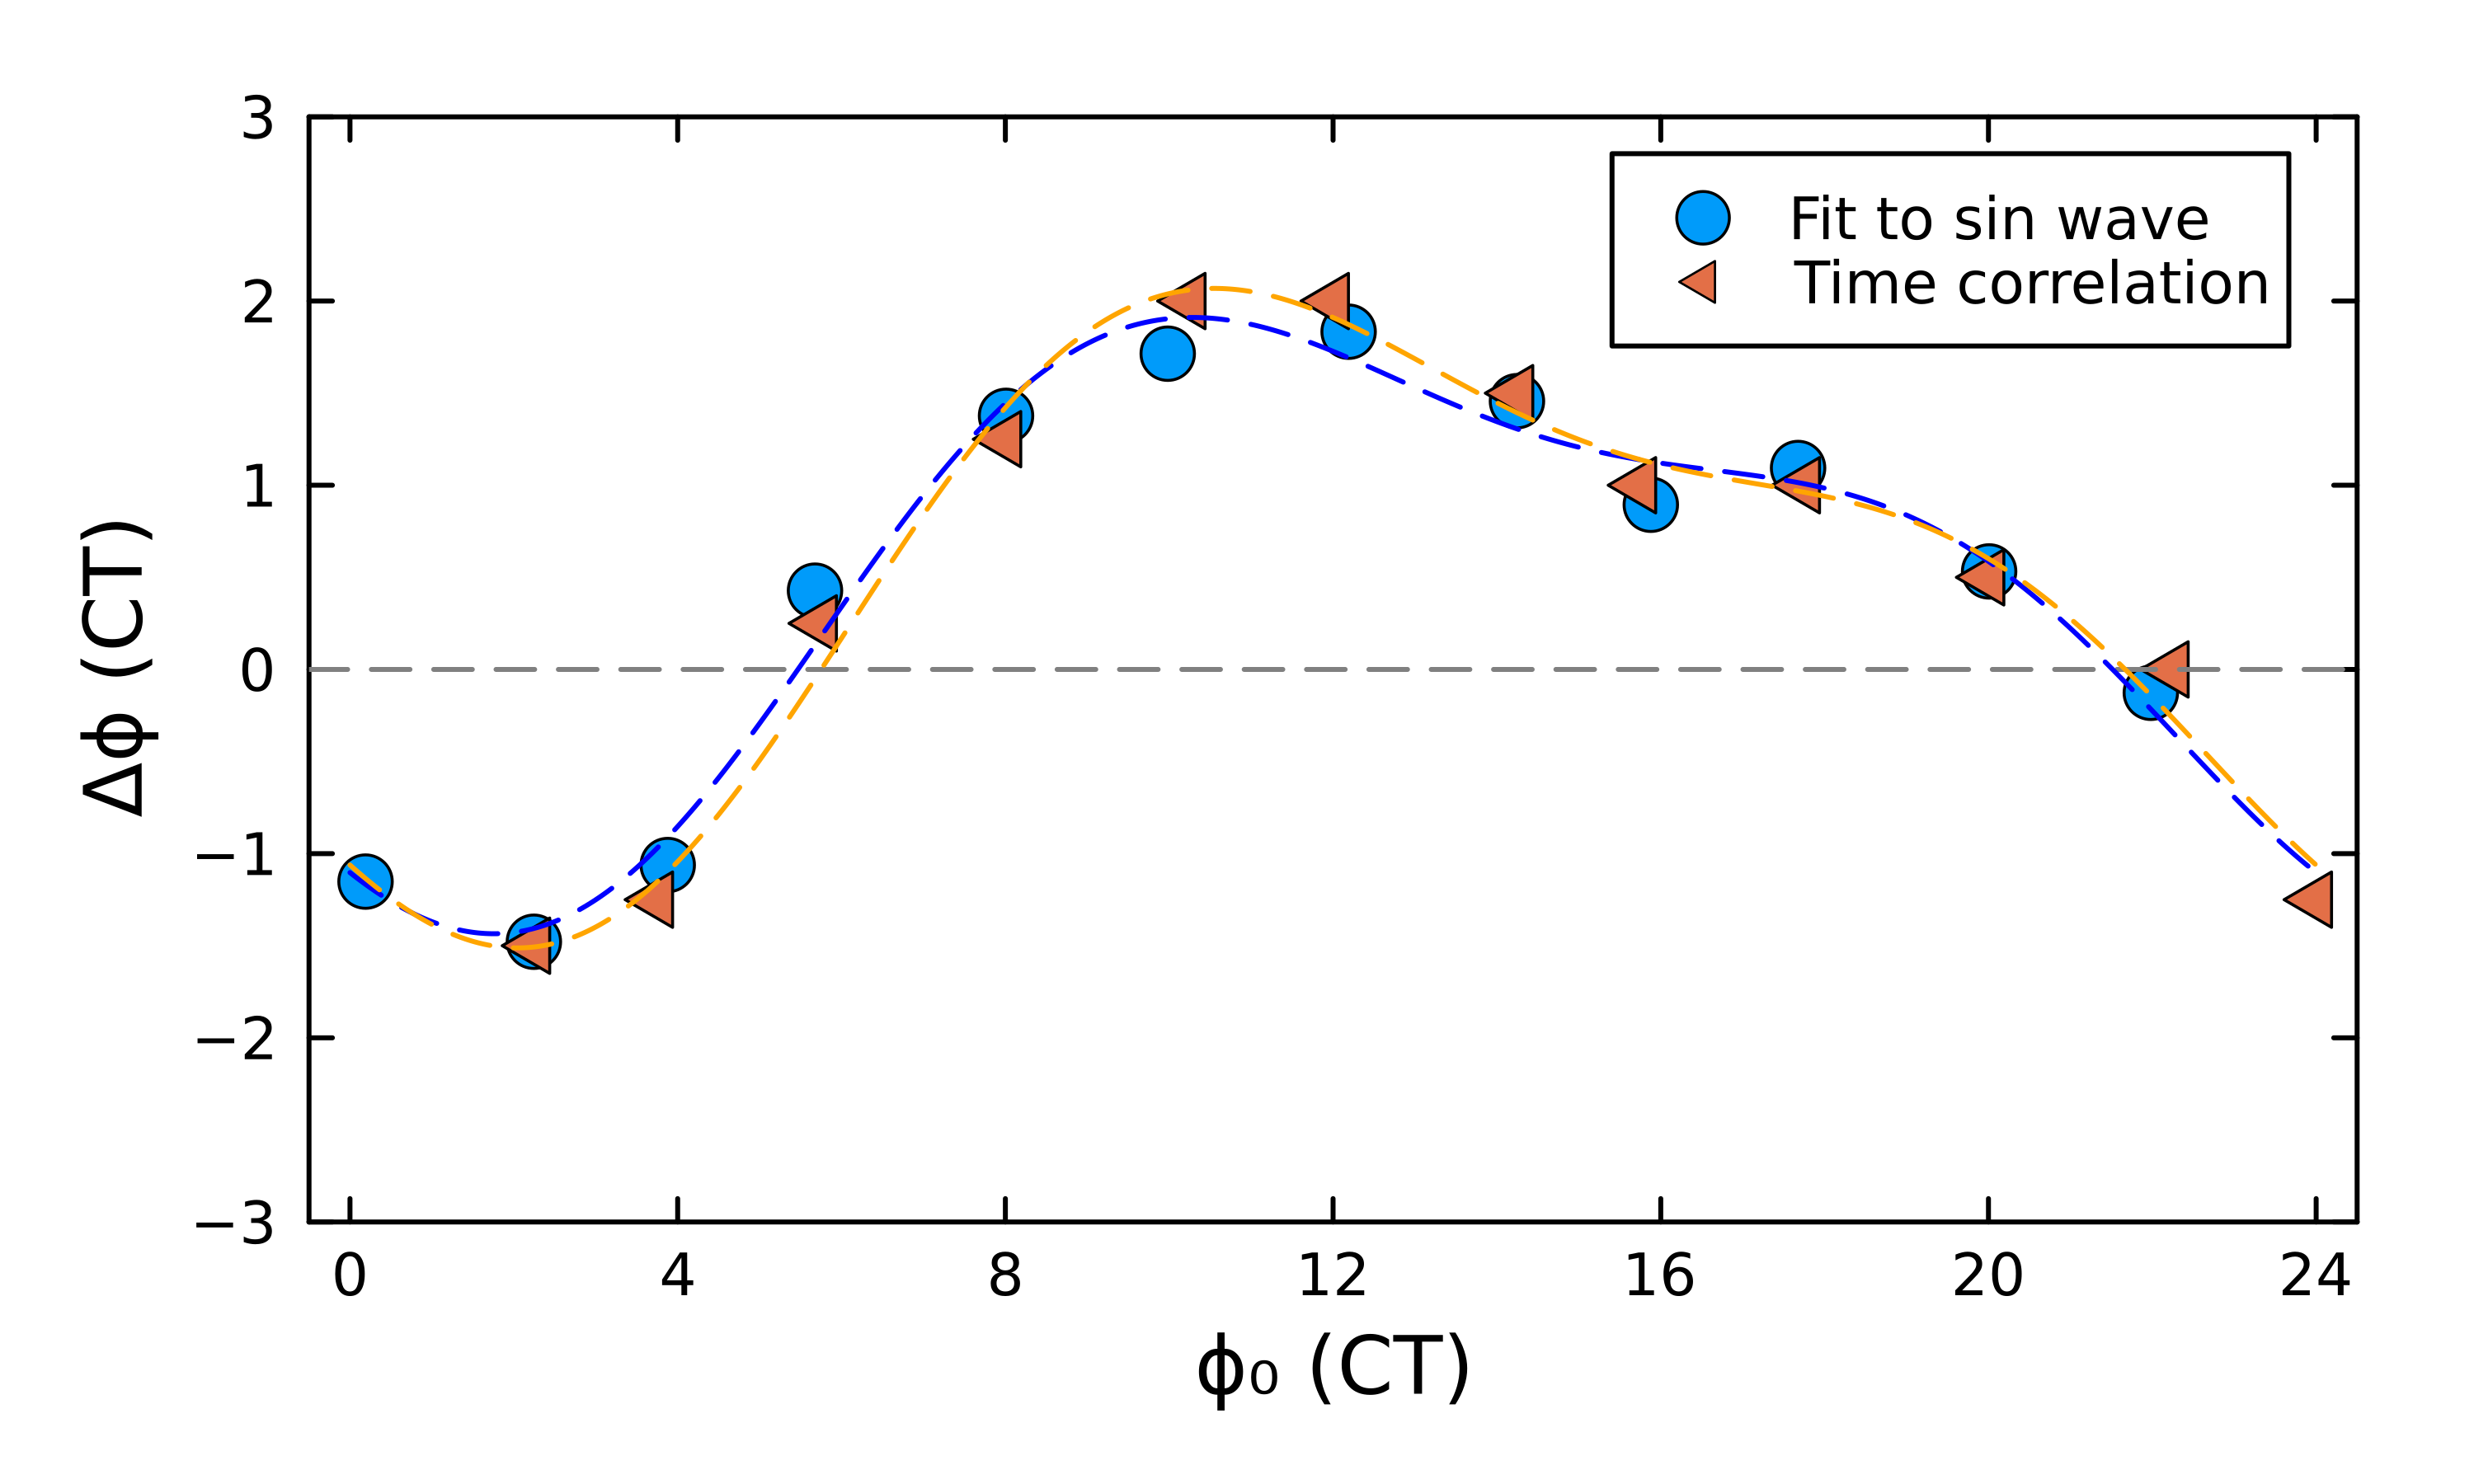

In [12]:
# initial parameters
p0 = [0.1, 2., π, 2., π]
lb = [0., 0., 0., 0., 0.]
ub = [10., 10., 2π, 10., 2π]
name_vec = ["A₀", "A₁", "ψ₁", "A₂", "ψ₂"]

fit_fit = curve_fit(prc_model, [fitted_ϕ₀[CT]/24*2π for CT in CT_vec],
                    [Δϕ_dict[CT] for CT in CT_vec], p0;
                    lower=lb, upper=ub)
println("Fit")
for i in 1:length(name_vec)
    println(name_vec[i]*(@sprintf " = %.2f" coef(fit_fit)[i]))
end

ϕ_span = 0:0.01:2π
plot!(pp, ϕ_span/(2π)*24, prc_model(ϕ_span, coef(fit_fit)),
    color=:blue, style=:dash, label=false)
    
fit_corr = curve_fit(prc_model, [fitted_ϕ₀2_bl[CT]/24*2π for CT in CT_vec],
                    [Δϕ_dict2[CT] for CT in CT_vec], p0;
                    lower=lb, upper=ub)
println("Time correlation")
for i in 1:length(name_vec)
    println(name_vec[i]*(@sprintf " = %.2f" coef(fit_corr)[i]))
end

ϕ_span = 0:0.01:2π
plot!(pp, ϕ_span/(2π)*24, prc_model(ϕ_span, coef(fit_corr)),
    color=:orange, style=:dash, label=false)

In [13]:
import DataFrames, CSV

In [128]:
# save the parameter estimates
df_p1 = DataFrame(Param=name_vec, Val=coef(fit_fit), Method=:Fit)
df_p2 = DataFrame(Param=name_vec, Val=coef(fit_corr), Method=:Corr)
df_p = vcat(df_p1, df_p2)

10×3 DataFrame
 Row │ Param   Val       Method 
     │ String  Float64   Symbol 
─────┼──────────────────────────
   1 │ A₀      0.487032  Fit
   2 │ A₁      1.4512    Fit
   3 │ ψ₁      3.36539   Fit
   4 │ A₂      0.538244  Fit
   5 │ ψ₂      4.38117   Fit
   6 │ A₀      0.489592  Corr
   7 │ A₁      1.53538   Corr
   8 │ ψ₁      3.39515   Corr
   9 │ A₂      0.568273  Corr
  10 │ ψ₂      4.59739   Corr

In [129]:
CSV.write("outputs/20240924_grc_fits.csv", df_p)

"outputs/20240924_grc_fits.csv"

Save estimated $\Delta\phi$ v.s. $\phi_0$

In [14]:
df = DataFrame(Expected_ϕ₀_CT = [CT_vec; CT_vec],
            Estimated_ϕ₀_CT = [[fitted_ϕ₀[CT] for CT in CT_vec]; [fitted_ϕ₀2[CT] for CT in CT_vec]],
            Δϕ_CT = [[Δϕ_dict[CT] for CT in CT_vec]; [Δϕ_dict2[CT] for CT in CT_vec]],
            Method = [repeat(["Fitting_sin"], length(CT_vec)); repeat(["Time_corr"], length(CT_vec))])

24×4 DataFrame
 Row │ Expected_ϕ₀_CT  Estimated_ϕ₀_CT  Δϕ_CT      Method      
     │ Int64           Real             Float64    String      
─────┼─────────────────────────────────────────────────────────
   1 │              0         2.24464   -1.47844   Fitting_sin
   2 │              2         3.87855   -1.062     Fitting_sin
   3 │              4         5.67613    0.427621  Fitting_sin
   4 │              6         8.00803    1.37681   Fitting_sin
   5 │              8         9.98184    1.7142    Fitting_sin
   6 │             10        12.1898     1.83351   Fitting_sin
   7 │             12        14.2446     1.45633   Fitting_sin
   8 │             14        15.8786     0.894107  Fitting_sin
   9 │             16        17.6761     1.09356   Fitting_sin
  10 │             18        20.008      0.53204   Fitting_sin
  11 │             20        21.9818    -0.126868  Fitting_sin
  ⋮  │       ⋮                ⋮             ⋮           ⋮
  15 │              4         3.5        0.25      Time_corr
  16 │              6         5.75       1.25      Time_corr
  17 │              8         8.0        2.0       Time_corr
  18 │             10         9.75       2.0       Time_corr
  19 │             12        12          1.5       Time_corr
  20 │             14        13.5        1.0       Time_corr
  21 │             16        15.5        1.0       Time_corr
  22 │             18        17.75       0.5       Time_corr
  23 │             20        20.0        0.0       Time_corr
  24 │             22        21.75      -1.25      Time_corr
                                                 3 rows omitted

In [15]:
# CSV.write("outputs/estimated_phi0_Deltaphi.csv", df)

## Implications on period and waveform

The above growth response curve is $GRC(\theta, M)$ where $M = 0.25$ is the magnitude of the growth perturbation, expressed as the ratio between new and existing protein. When $M$ is small we guess that the growth response curve scales linear with $M$ i.e.

$$
GRC(\theta, M) = M\cdot grc(\theta)
$$

Let's call $grc(\theta)$ the magnitude-independent growth response function.

Suppose the circadian oscillator is described by

$$
\frac{d}{dt}\theta = \omega + f(\theta, r)
$$

Where $f(\theta, r)$ is the contribution of growth. 
At phase $\phi$, the phase shift by growth in a short time window $\Delta t$ is
$f(\theta, r)\Delta t$.

Assume that $f(\theta, r)$ scales linearly with growth rate, i.e.

$$
f(\theta, r) = r\cdot f'(\theta)
$$

Then the phase shift is

$$
\Delta \theta = r\cdot f'(\theta)\Delta t
$$

The same phase shift at phase $\theta$ described by the phenomenological growth response function is

$$
\Delta \theta = M\cdot grc(\theta)
$$

Though the growth response curve implies nothing about the growth rate of the system, we know that the accumulated increase in the size of a system of growth rate $r$ over a short time window $\Delta t$ is $\Delta V = V_0 r \Delta t$, which means

$$
M = r\Delta t
$$

From the above three equations it is easy to see that

$$
f'(\theta) = grc(\theta)
$$

Which then gives a description for a circadian oscillator in a growing cell,

$$
\frac{d}{dt}\theta = \omega + r\cdot grc(\theta)
$$

or

$$
\frac{d}{dt}\theta = \omega + r\cdot GRC(\theta)/M
$$

Consequentially, the period under growth is

$$
T = \int_0^T dt = \int_0^{2\pi} \frac{d\theta}{\omega + r\cdot grc(\theta)}
$$

In [125]:
using Integrals
using Cubature
using Cuba

In [17]:
function f(u, p)
    θ = u[1]
    ω, r, grc = p
    1/(ω + r*grc(θ))
end

f (generic function with 1 method)

In [83]:
prc_model(3π, coef(fit_fit))

1.727007451306727

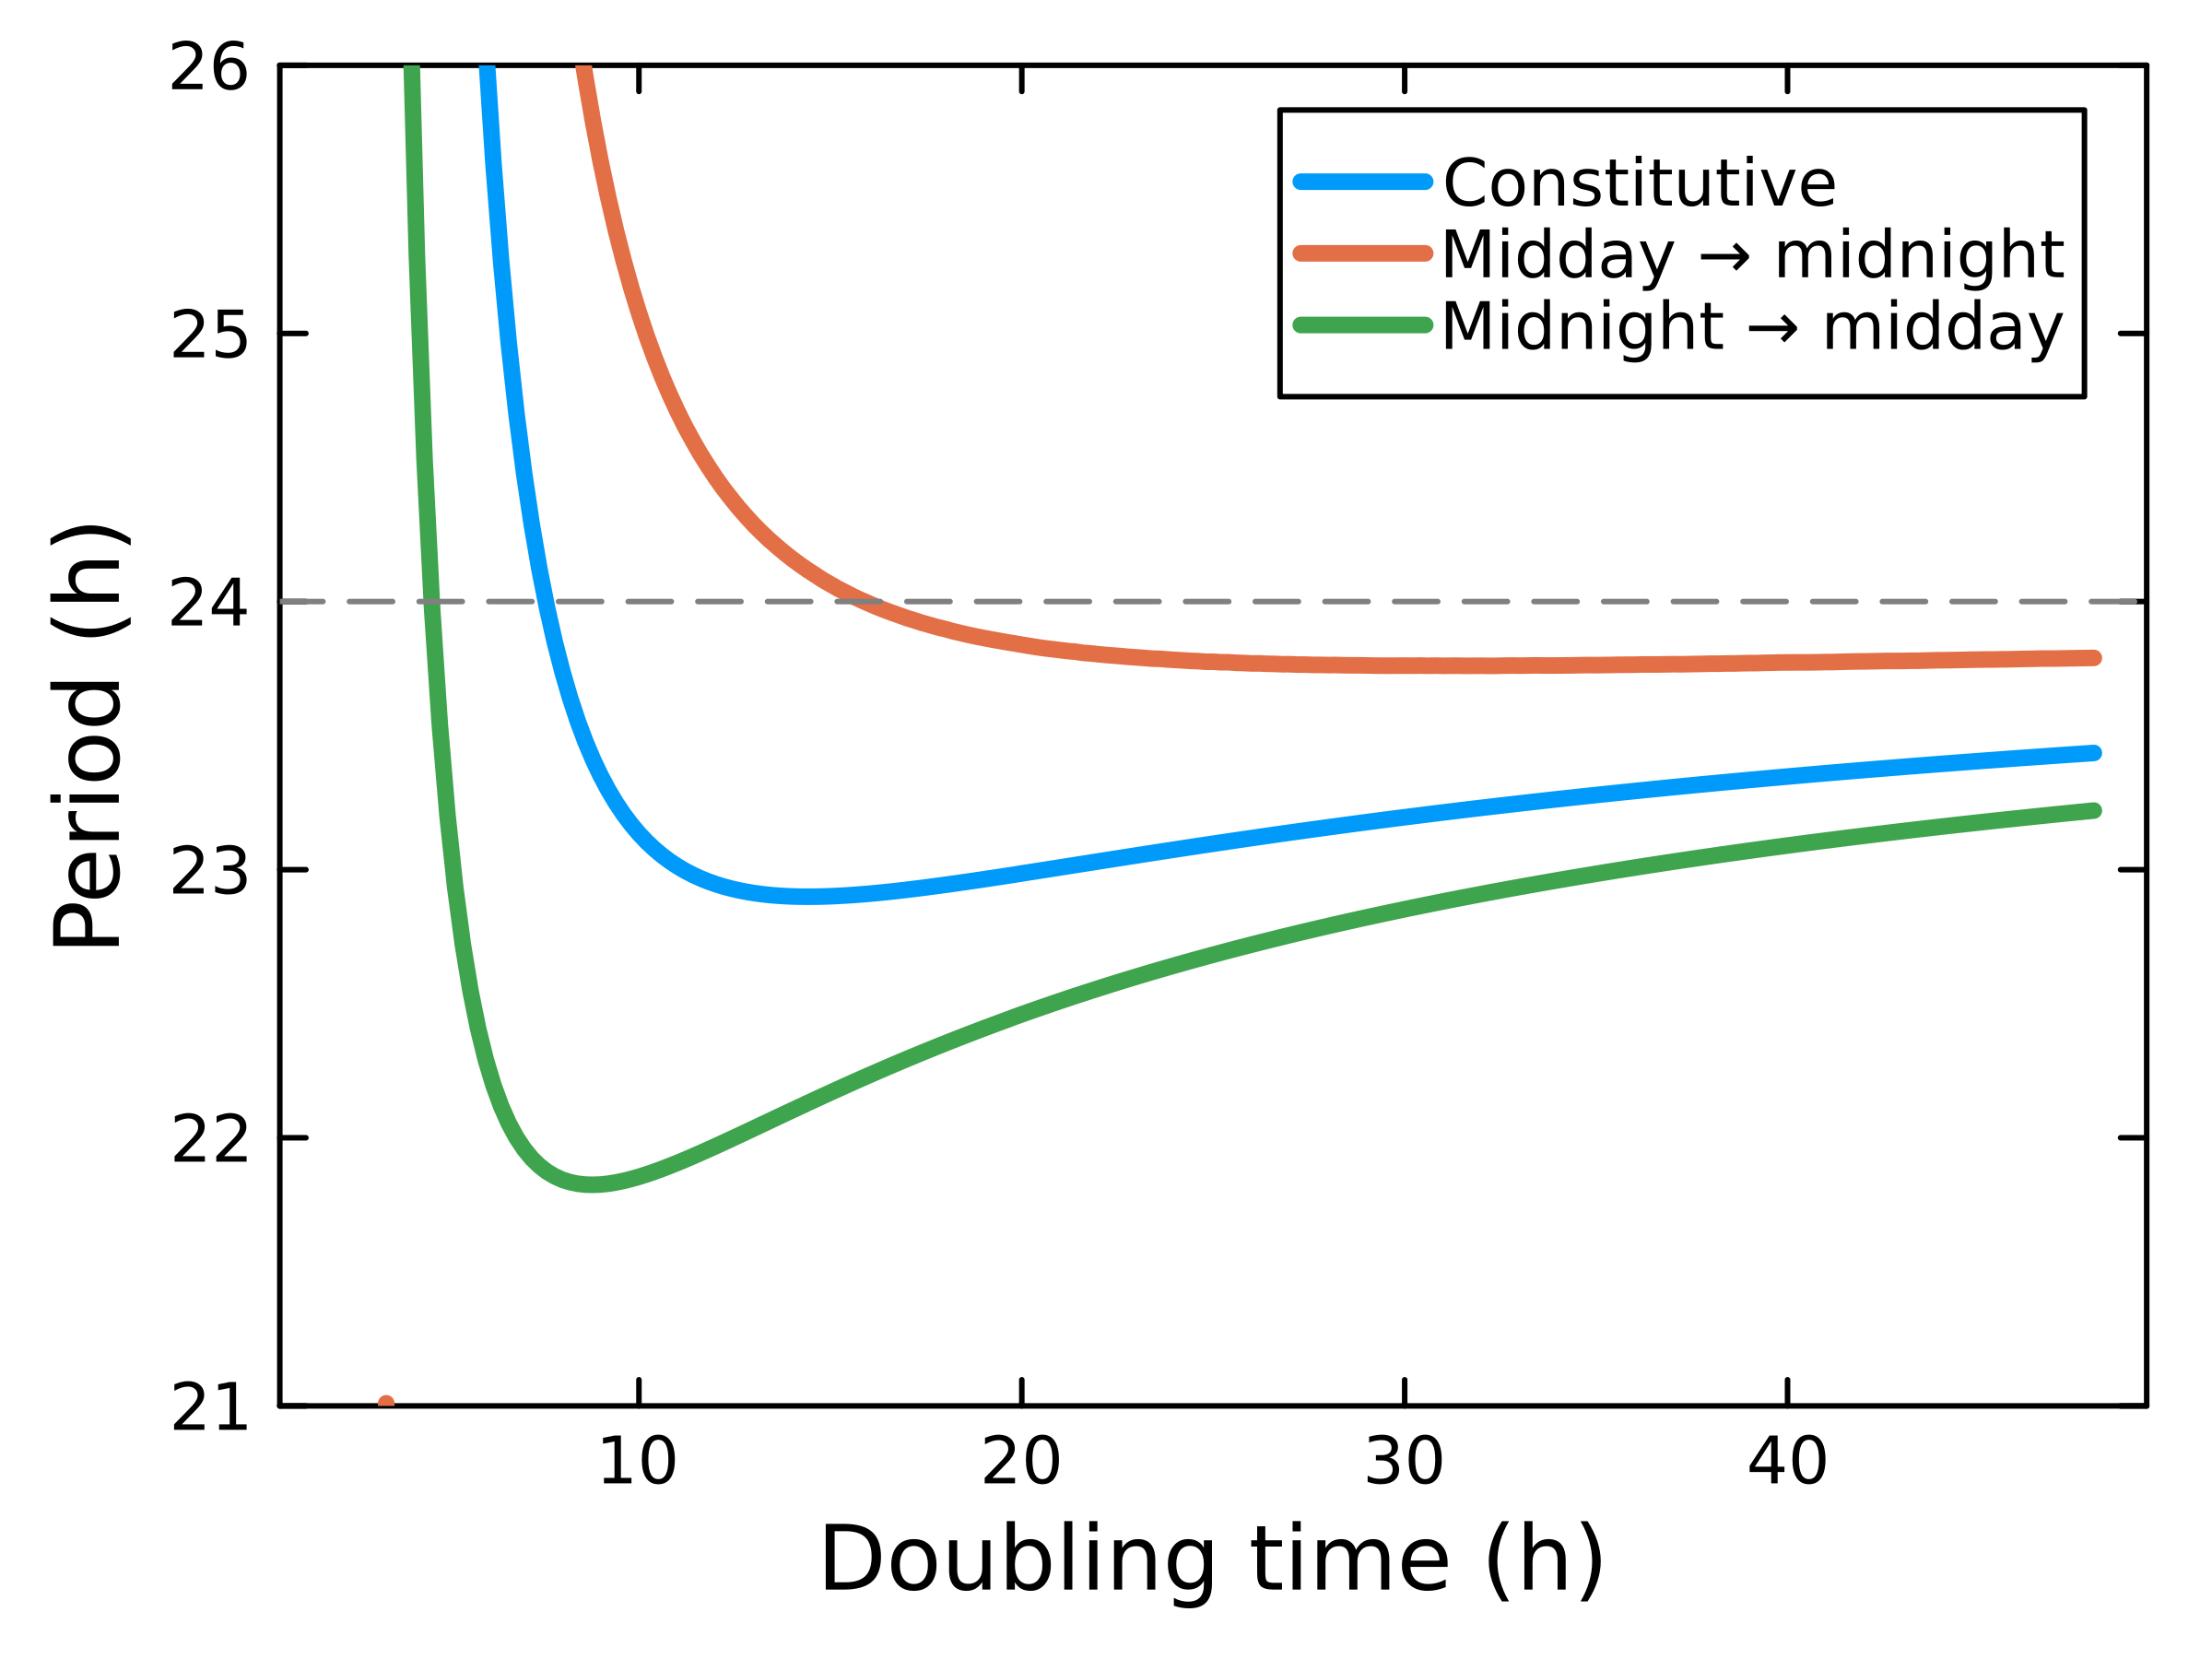

In [127]:
g_vec = 2:0.2:48
M = 0.25

grc_vec = (θ -> prc_model(θ, coef(fit_fit))/M*2π/24,
            θ -> (θ -> θ < 2π/3 || θ >= π ? 6/5 : 0)(θ)*prc_model(θ, coef(fit_fit))/M*2π/24,
            θ -> (sin(θ - π) + 1)*prc_model(θ, coef(fit_fit))/M*2π/24)

plot(frame=:box, grid=false, xlabel="Doubling time (h)", ylabel="Period (h)",
    ylim=(21, 26), fmt=:png, size=(400, 300), dpi=600)

label_vec = ["Constitutive", "Midday → midnight", "Midnight → midday"]

for i in 1:3
    
    T_vec = []
    
    for g in g_vec
        if g < cutoff_vec[i]
            continue
        end
        prob = IntegralProblem(f, (0, 2π), (2π/24, log(2)/g, grc_vec[i]))
        sol = solve(prob, CubaVegas())
        T_vec = [T_vec; sol.u]
    end
    
    plot!(g_vec[T_vec .> 0], T_vec[T_vec .> 0], label=label_vec[i], linewidth=3)
end

hline!([24], style=:dash, color=:gray, label=false)

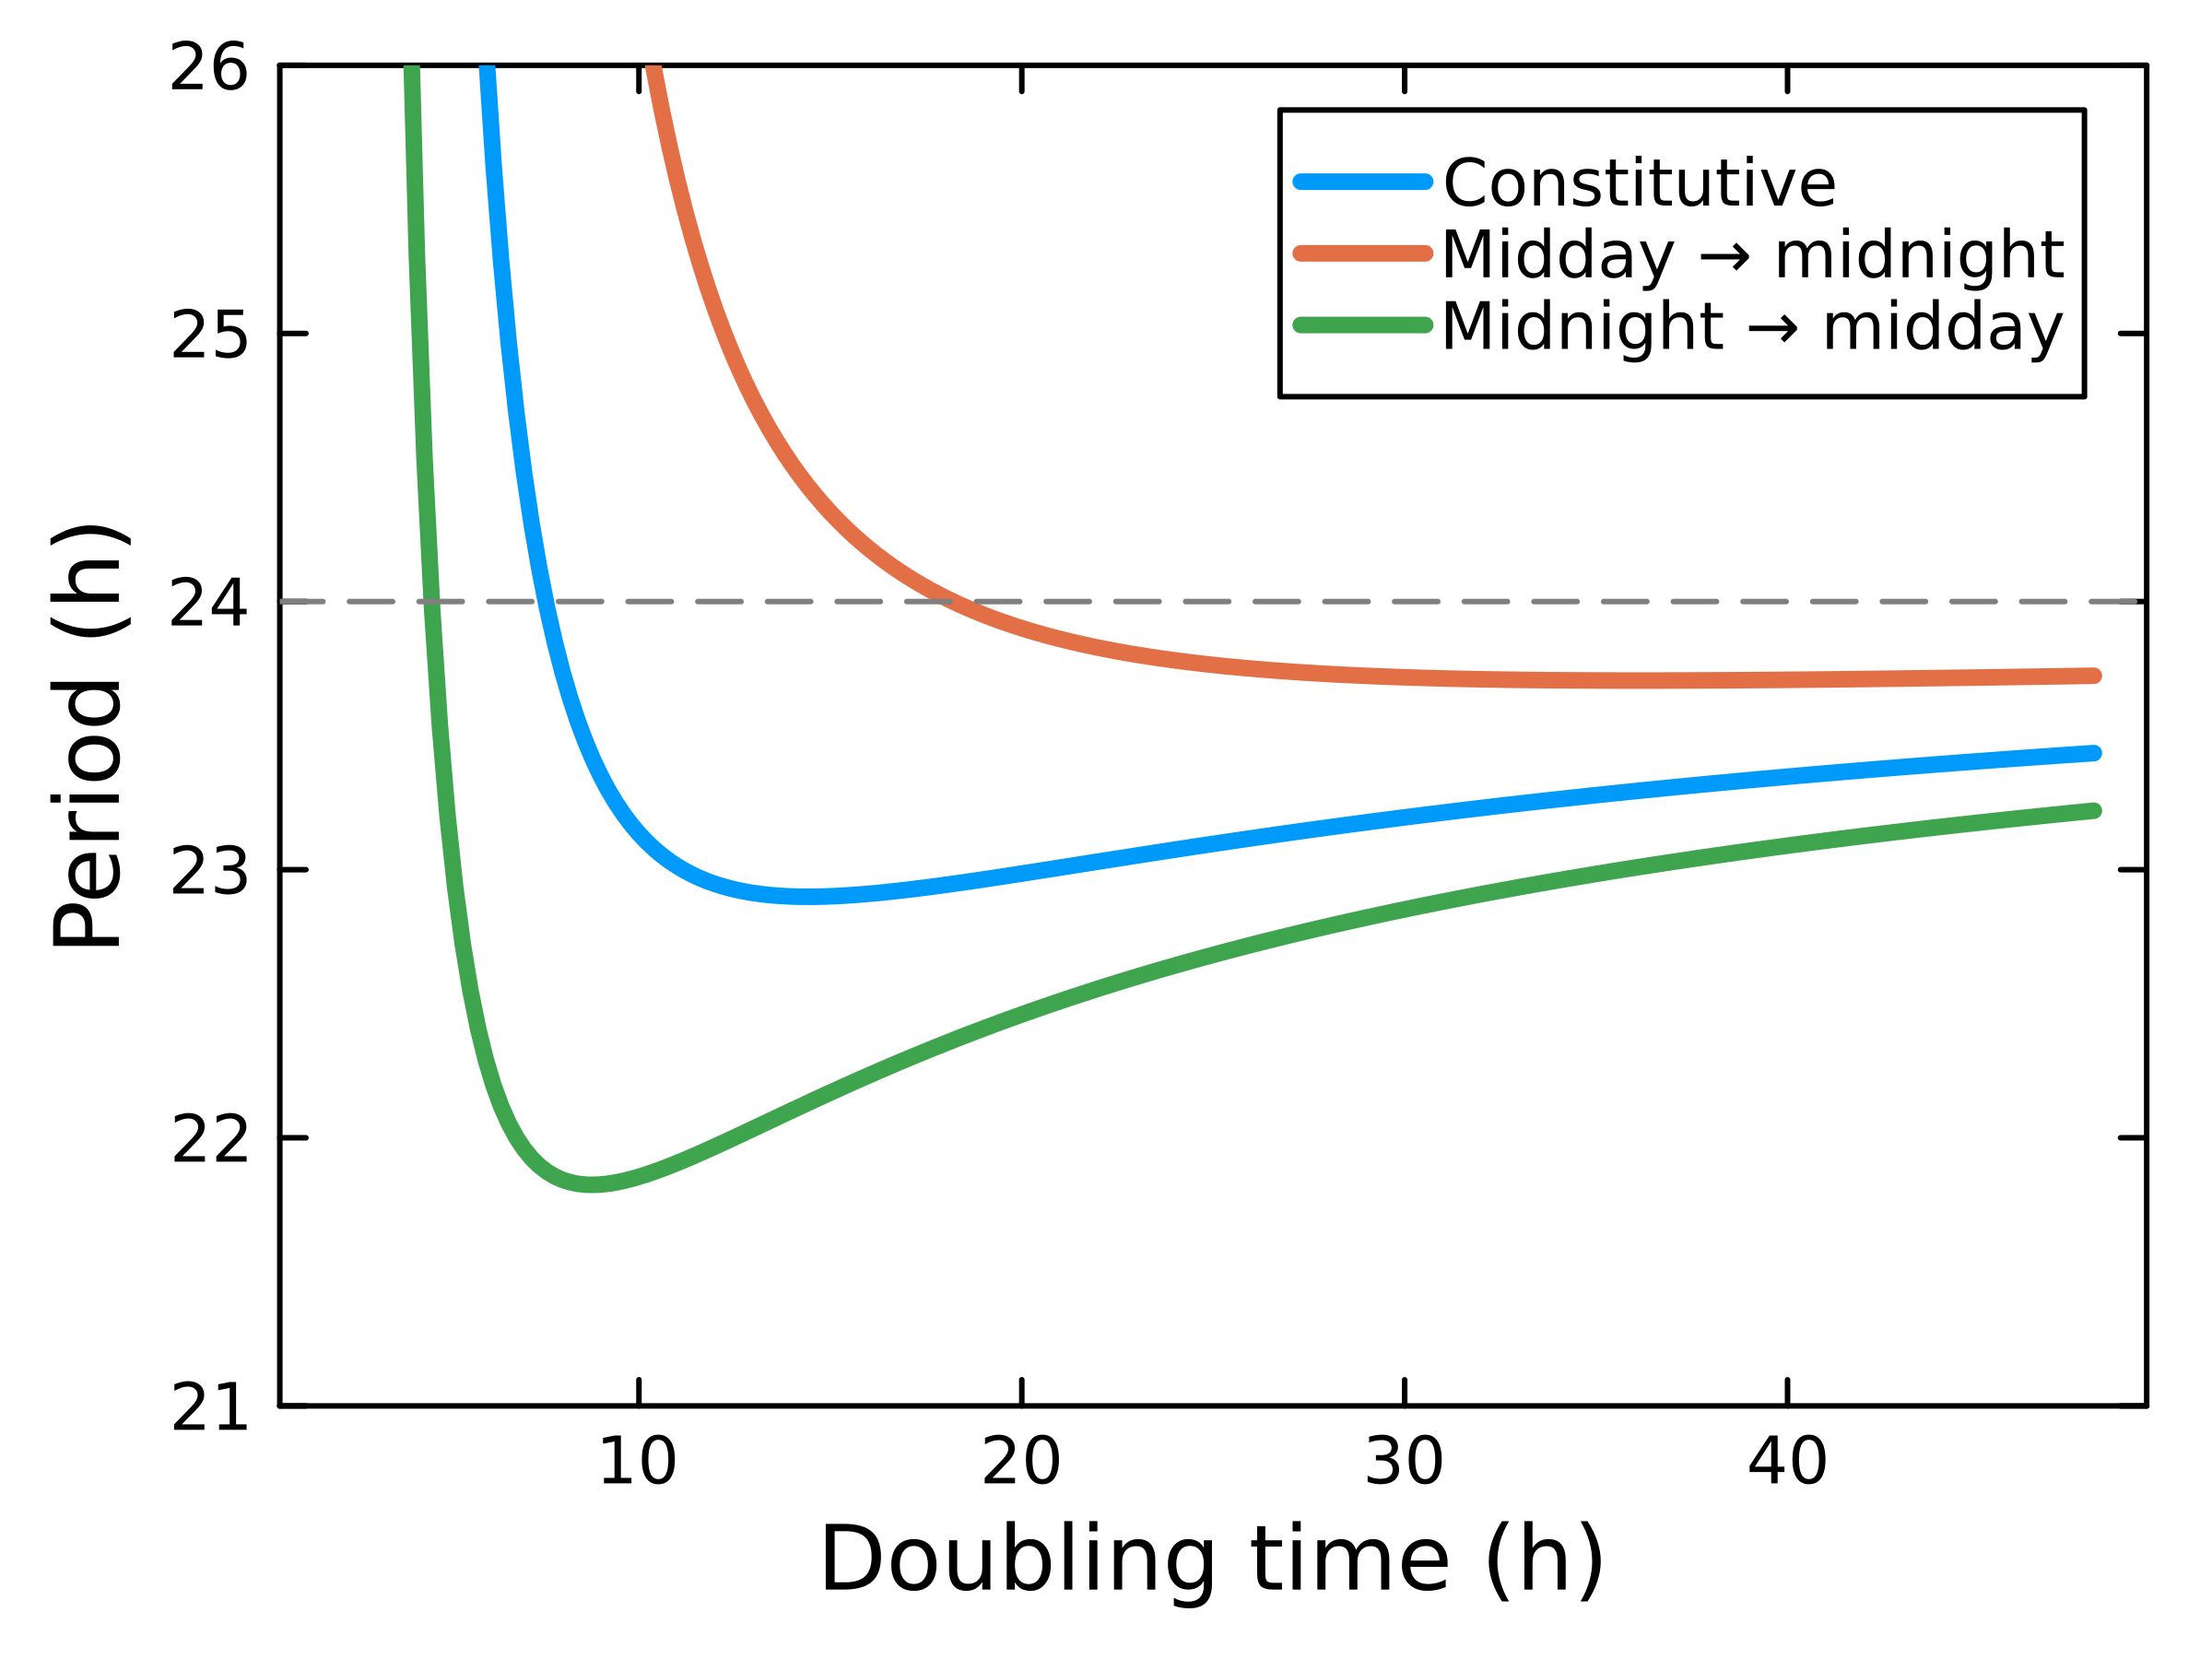

In [101]:
g_vec = 2:0.2:48
M = 0.25

grc_vec = (θ -> prc_model(θ, coef(fit_fit))/M*2π/24,
            θ -> (sin(θ) + 1)*prc_model(θ, coef(fit_fit))/M*2π/24,
            θ -> (sin(θ - π) + 1)*prc_model(θ, coef(fit_fit))/M*2π/24)

plot(frame=:box, grid=false, xlabel="Doubling time (h)", ylabel="Period (h)",
    ylim=(21, 26), fmt=:png, size=(400, 300), dpi=600)

label_vec = ["Constitutive", "Midday → midnight", "Midnight → midday"]

for i in 1:3
    
    T_vec = []
    
    for g in g_vec
        if g < cutoff_vec[i]
            continue
        end
        prob = IntegralProblem(f, (0, 2π), (2π/24, log(2)/g, grc_vec[i]))
        sol = solve(prob, HCubatureJL(); reltol=1e-4, abstol=1e-4)
        T_vec = [T_vec; sol.u]
    end
    
    plot!(g_vec[T_vec .> 20], T_vec[T_vec .> 20], label=label_vec[i], linewidth=3)
end

hline!([24], style=:dash, color=:gray, label=false)

## Connecting the experimental results to a minimal model

A __growth response curve__, denoted by $F$, maps out the phase shift when a pulse of growth perturbation happens at a certain phase, i.e.

$$
\phi \mapsto F(\phi; r, \Delta t)
$$

With the two parameters $r$ being the growth rate and $\Delta t$ being the during of the pulse.
To make it concrete, $r$ is the first-order expansion rate of the system.
The growth rate of a bacterial population is often expressed in its doubling time, $g$,
which is the time it takes to double (the volume or the number of cells of) the system.
The two parameters are related by $r = \ln(2)/g$.

Assume that a "good" growth response curve scales linearly with small $r$ and $\Delta t$, i.e.

$$
F(\phi; r, \Delta t) = r\cdot f(\phi)\Delta t
$$

Here we call $f$ the __"unit" growth response function__.

Note that $r\Delta t$ is the ratio of expansion in a small time window i.e. $\Delta V(\Delta t)/V_0 = r\Delta t$. Let us denote it as $M$, the magnitude of the transient perturbation.

$$
M = r\Delta t
$$

This notation is helpful because in experiments where transient perturbation is applied the growth rate and the duration of the perturbation are undefined. Only $M$, the ratio of new material added, is known.

In summary, to infer a unit growth response function from an experimentally measured growth response curve we use

$$
f(\phi) = F(\phi)/M
$$

Given that the growth response curve scales linearly with both the growth rate and the during of the growth pulse.
This is because

$$
\begin{align}
\Delta \phi &= F(\phi; r, \Delta t)\\
&= r\cdot f(\phi)\Delta t\\
&= M\cdot f(\phi)
\end{align}
$$

The unit growth response function is the cornerstone to predict the effect of continue growth. 
E.g. a minimal model is given by

$$
\frac{d}{dt}\phi = \omega + r\cdot f(\phi)
$$

In [19]:
using DifferentialEquations

In [20]:
function rhs(u, p, t)
    θ = u[1]
    ω, r, grc = p
    dudt = [ω + r*grc(θ)]
    dudt
end

rhs (generic function with 1 method)

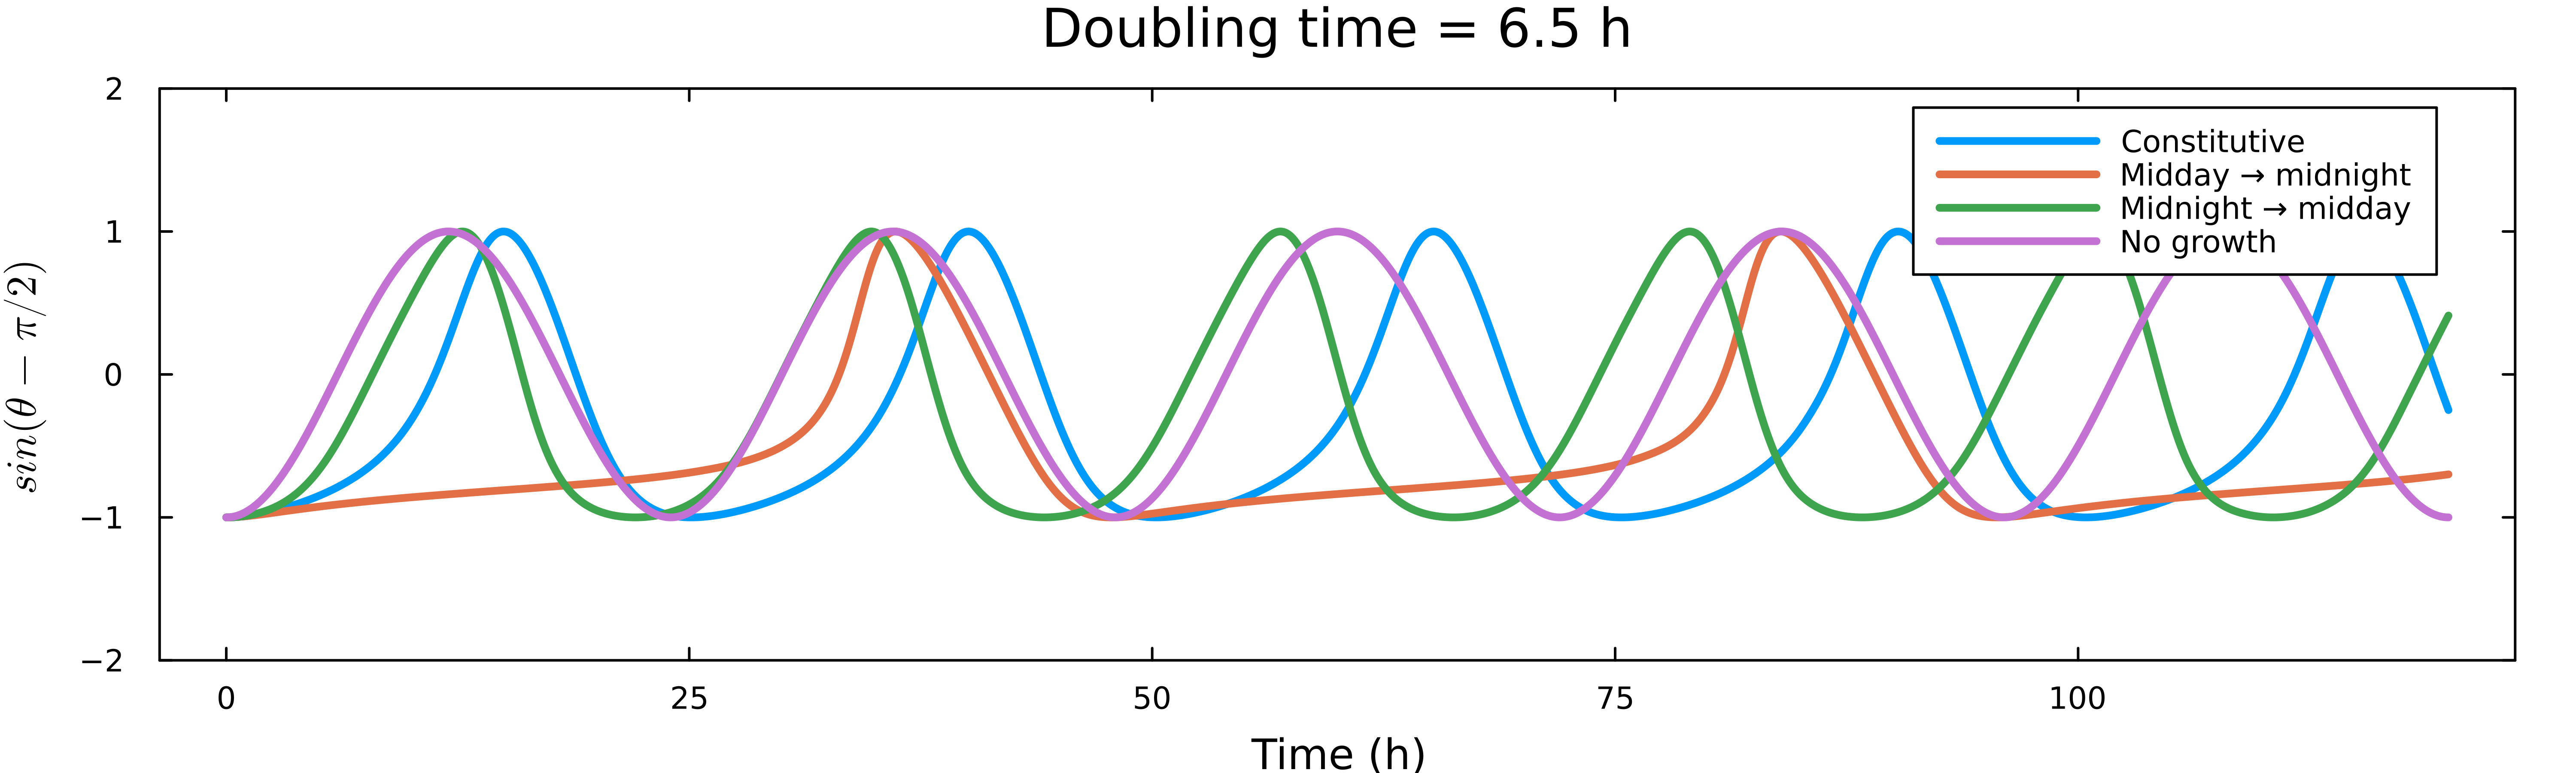

In [92]:
plot(frame=:box, grid=false, xlabel="Time (h)", ylabel="\$sin(\\theta - \\pi/2)\$",
    ylim=(-2, 2), fmt=:png, size=(1000, 300), dpi=600, margins=4Plots.mm, legend=:best)

label_vec = ["Constitutive", "Midday → midnight", "Midnight → midday", "No growth"]

θ₀ = 0.
tspan = (0., 120.)
G = 6.5

for i in 1:4
    prob = ODEProblem(rhs, [θ₀], tspan, (2π/24, log(2)/G, i < 4 ? grc_vec[i] : θ -> 0))
    sol = solve(prob, Tsit5(); saveat=0.1, reltol=1e-4, abstol=1e-4)
    plot!(sol.t, sin.([u[1] for u in sol.u] .- π/2), label=label_vec[i], linewidth=3)
end

plot!(title="Doubling time = $(G) h")